## Step 1: Load Libraries and Data

In [1]:
# Install all required packages
!pip install pandas krippendorff statsmodels scikit-learn seaborn matplotlib numpy nltk


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.inter_rater import aggregate_raters, fleiss_kappa
import itertools
import seaborn as sns
from scipy.stats import entropy
from sklearn.cluster import KMeans
from scipy.special import rel_entr
from scipy.stats import entropy
import itertools
from collections import Counter
import pandas as pd
import ast 
from statsmodels.stats.inter_rater import fleiss_kappa
from itertools import product
from nltk.metrics import agreement
from nltk.metrics import masi_distance
from collections import defaultdict
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
df = pd.read_csv("./gold_dataset.csv")
df.head()

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,LifetimeApprovalRate,Last30DaysApprovalRate,Last7DaysApprovalRate,Input.text-eng,Input.label,Input.parameter,Input.parameter_num_labels,Answer.manifesto_class.labels,Approve,Reject
0,39N6W9XWS05H65P9I0HAUP0E2RZGYY,3BRS3IGD63EV308CIXT46SFWM41TR3,[ACSS] Text labeling Manifesto,Identify the most relevant labels to describe ...,"labeling, text, manifesto",$1.00,Mon Apr 14 05:38:01 PDT 2025,3,BatchId:414859;OriginalHitTemplateId:921587261;,3600,...,100% (152/152),100% (46/46),100% (46/46),"Madam President, Mr Posselt, I do not really t...",0,Par303_Governmental and Administrative Efficiency,2,[],NaN,NaN
1,39N6W9XWS05H65P9I0HAUP0E2RZGYY,3BRS3IGD63EV308CIXT46SFWM41TR3,[ACSS] Text labeling Manifesto,Identify the most relevant labels to describe ...,"labeling, text, manifesto",$1.00,Mon Apr 14 05:38:01 PDT 2025,3,BatchId:414859;OriginalHitTemplateId:921587261;,3600,...,100% (238/239),100% (19/19),100% (19/19),"Madam President, Mr Posselt, I do not really t...",0,Par303_Governmental and Administrative Efficiency,2,[],NaN,NaN
2,39N6W9XWS05H65P9I0HAUP0E2RZGYY,3BRS3IGD63EV308CIXT46SFWM41TR3,[ACSS] Text labeling Manifesto,Identify the most relevant labels to describe ...,"labeling, text, manifesto",$1.00,Mon Apr 14 05:38:01 PDT 2025,3,BatchId:414859;OriginalHitTemplateId:921587261;,3600,...,100% (287/287),100% (75/75),100% (19/19),"Madam President, Mr Posselt, I do not really t...",0,Par303_Governmental and Administrative Efficiency,2,[],NaN,NaN
3,3P7RGTLO71VLC9NPSLO9PVA06HDAKL,3BRS3IGD63EV308CIXT46SFWM41TR3,[ACSS] Text labeling Manifesto,Identify the most relevant labels to describe ...,"labeling, text, manifesto",$1.00,Mon Apr 14 05:38:01 PDT 2025,3,BatchId:414859;OriginalHitTemplateId:921587261;,3600,...,100% (152/152),100% (46/46),100% (46/46),"Mr President, ladies and gentlemen, first of a...",1,Par405_Corporatism,2,"[""Keynesian Demand Management"",""Market regulat...",NaN,NaN
4,3P7RGTLO71VLC9NPSLO9PVA06HDAKL,3BRS3IGD63EV308CIXT46SFWM41TR3,[ACSS] Text labeling Manifesto,Identify the most relevant labels to describe ...,"labeling, text, manifesto",$1.00,Mon Apr 14 05:38:01 PDT 2025,3,BatchId:414859;OriginalHitTemplateId:921587261;,3600,...,100% (287/287),100% (75/75),100% (19/19),"Mr President, ladies and gentlemen, first of a...",1,Par405_Corporatism,2,"[""Government and administrative efficiency"",""M...",NaN,NaN


#### **Data Cleaning and Pre-Proccessing**

In [64]:
# only keep needed columns and rename 
df_clean = df[['HITId', 'WorkerId', 'Answer.manifesto_class.labels']].copy() #remove unnecessary columns
df_clean.rename(columns={
    'HITId': 'speech_id',
    'WorkerId': 'worker_id',
    'Answer.manifesto_class.labels': 'answer'
}, inplace=True)
df_clean = df_clean.sort_values(by=['speech_id', 'worker_id']).reset_index(drop=True)

# Final preview
df_clean

,speech_id,worker_id,answer
0,301KG0KXAZ355GRD9LSX6LBA2CHH2H,A1NBQ61Y6KO3O9,"[""Market regulation"",""Middle Class & Professio..."
1,301KG0KXAZ355GRD9LSX6LBA2CHH2H,A1X47COW2Y9SEL,"[""Market regulation""]"
2,301KG0KXAZ355GRD9LSX6LBA2CHH2H,A335R4YE2E34H6,"[""Market regulation""]"
3,302OLP89EMP3TBB1087B1CXS184CAA,A1NBQ61Y6KO3O9,"[""Government and administrative efficiency"",""E..."
4,302OLP89EMP3TBB1087B1CXS184CAA,A1X47COW2Y9SEL,"[""Economic Goals""]"
...,...,...,...
655,3ZXNP4Z3AE3EDD796IOQU4LPUM0L7M,A1X47COW2Y9SEL,"[""Market regulation"",""Government and administr..."
656,3ZXNP4Z3AE3EDD796IOQU4LPUM0L7M,A3GS2NTQ4XU059,"[""Free Market Economy""]"
657,3ZXV7Q5FKY6YP2S9BOT3FD8JYOHCFN,A1BQ37ZGUM16XI,"[""Market regulation""]"
658,3ZXV7Q5FKY6YP2S9BOT3FD8JYOHCFN,A1X47COW2Y9SEL,"[""Market regulation"",""Anti-Growth Economy""]"


TODO: Change df_clean so that [] answers are now ['None']; then add 'None' to unique categories and recheck the arbitrary worker knowledge

define workers and 'categories' - the list of categories they chose from for answers

In [75]:
workers = [
    'A1BQ37ZGUM16XI', 
    'A1NBQ61Y6KO3O9', 
    'A1X47COW2Y9SEL', 
    'A335R4YE2E34H6', 
    'A3GS2NTQ4XU059', 
    'APXGSUB250NVH'
]

with open("../Outputs/unique_categories.json", "r") as f:
    unique_categories = json.load(f)

unique_categories

 

['Market regulation',
 'Middle Class & Professional Groups',
 'Government and administrative efficiency',
 'Economic Planning',
 'Economic Goals',
 'Anti-Growth Economy',
 'Economic Growth',
 'Free Market Economy',
 'Incentives',
 'Keynesian Demand Management',
 'Corporatism / Mixed Economy',
 'Technology and Infrastructure',
 'Labor Groups Positive',
 'Labor Groups Negative',
 'None']

Now, we try to pivot the data to create different dataframes for every speech !! TODO: add row for 'no label'

In [66]:

df_clean['answer'] = df_clean['answer'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_filtered = df_clean[df_clean['answer'].apply(lambda x: isinstance(x, list))] 
df_filtered['answer'] = df_filtered['answer'].apply(lambda x: ['None'] if isinstance(x, list) and len(x) == 0 else x)



speech_dfs = {} # result dict

for speech_id, group in df_filtered.groupby('speech_id'):
    if len(group) != 3:
        continue  # skip if not exactly 3 annotations

    df = pd.DataFrame(index=unique_categories)  # rows = categories
    for i, (_, row) in enumerate(group.iterrows()):
        worker_label = f'worker{i+1}'
        df[worker_label] = df.index.map(lambda category: 1 if category in row['answer'] else 0)

    speech_dfs[speech_id] = df

        
speech_dfs['306996CF7J2OPI6VQPINFRY7FTYB1E']

,worker1,worker2,worker3
Market regulation,1,0,0
Middle Class & Professional Groups,0,0,0
Government and administrative efficiency,0,1,0
Economic Planning,0,0,1
Economic Goals,0,0,0
Anti-Growth Economy,1,0,0
Economic Growth,0,0,1
Free Market Economy,0,0,0
Incentives,0,0,0
Keynesian Demand Management,0,0,0


## Run Fleiss Kappa

Run on every speech and create a new df to see the results

In [67]:


# Store results
kappa_scores = []

for speech_id, df in speech_dfs.items():
    # Each row is a category → count number of 1s and 0s across workers
    count_matrix = []
    for _, row in df.iterrows():
        counts = [list(row).count(0), list(row).count(1)]  # [num 0s, num 1s]
        count_matrix.append(counts)

    count_array = np.array(count_matrix)

    # Compute Fleiss' Kappa
    try:
        kappa = fleiss_kappa(count_array)
    except Exception as e:
        print(f"Error on {speech_id}: {e}")
        kappa = np.nan

    kappa_scores.append({
        'speech_id': speech_id,
        'fleiss_kappa': kappa
    })

# Convert to DataFrame
df_kappa = pd.DataFrame(kappa_scores)


In [68]:
df_kappa

,speech_id,fleiss_kappa
0,301KG0KXAZ355GRD9LSX6LBA2CHH2H,0.725610
1,302OLP89EMP3TBB1087B1CXS184CAA,0.100000
2,306996CF7J2OPI6VQPINFRY7FTYB1E,-0.125000
3,3087LXLJ79YEVAXTZ80JKC6IPZKF0X,0.492481
4,308KJXFUKEOKFSDCMU21QMXWPU4ATR,0.423077
...,...,...
215,3YZ7A3YHSSBMUMOG2Y6U86LOVAD5S5,0.166667
216,3ZUE82NE1XJWDZ2WUCDYDRC08AKF8Y,0.230769
217,3ZURAPD29V5E2ZIBVR4JYHPSURQF10,0.492481
218,3ZXNP4Z3AE3EDD796IOQU4LPUM0L7M,0.154135


In [69]:
avg_kappa = df_kappa['fleiss_kappa'].mean()
print(f"Average Fleiss' Kappa: {avg_kappa:.3f}")

Average Fleiss' Kappa: 0.288


Save the df_kappa dataframe to a csv for easy viewing/sharing

In [10]:

df_kappa.to_csv('../Outputs/Fleiss_Kappa_per_Speech', index=False)

trying to organize distribution of fleiss kappa scores

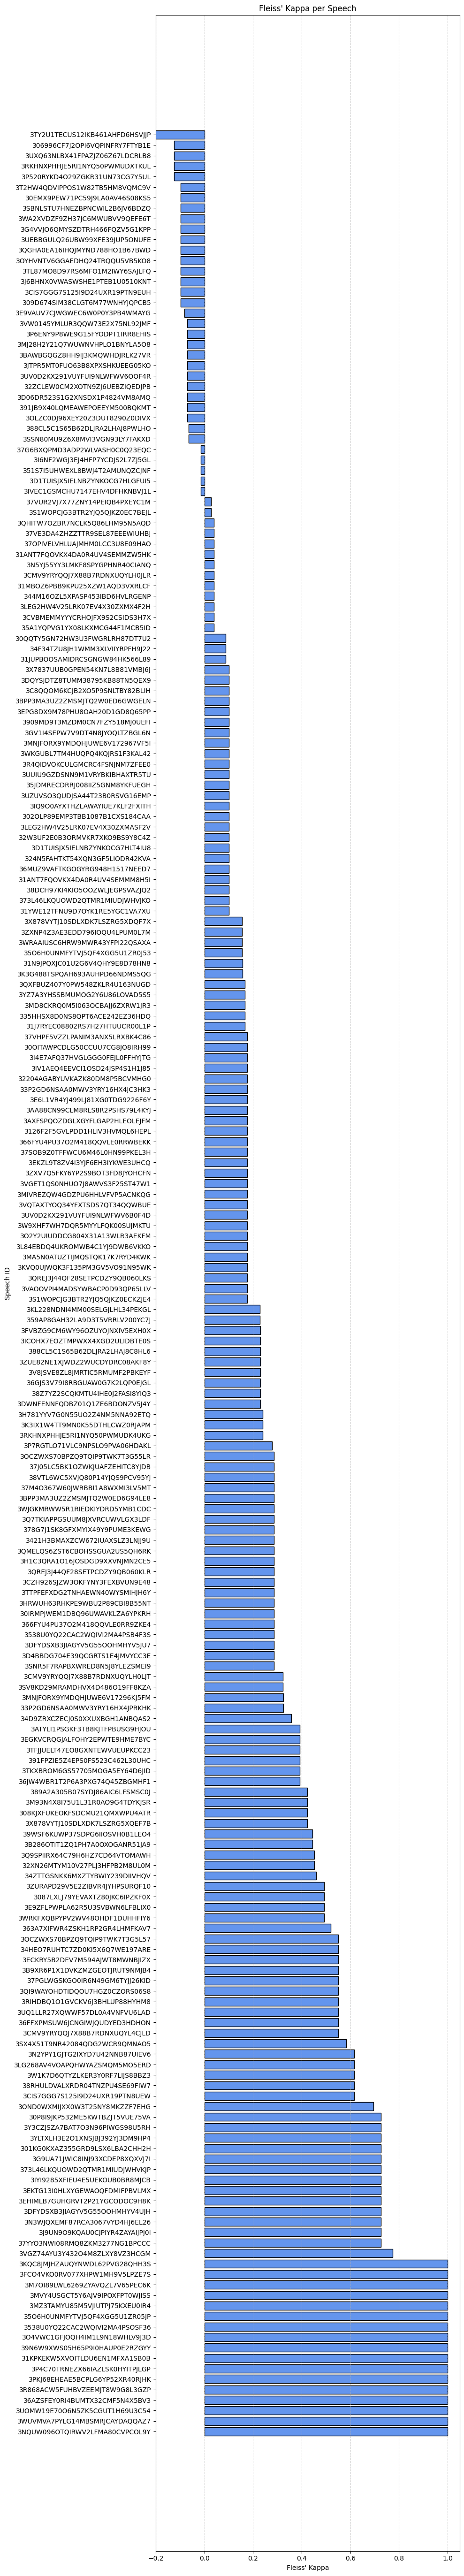

In [70]:
# Sort by Fleiss' Kappa if desired (optional)
df_kappa_sorted = df_kappa.sort_values(by='fleiss_kappa', ascending=False)

# Set figure size based on number of speeches
plt.figure(figsize=(10, len(df_kappa_sorted) * 0.25))

# Plot horizontal bar chart
plt.barh(df_kappa_sorted['speech_id'], df_kappa_sorted['fleiss_kappa'], color='cornflowerblue', edgecolor='black')

plt.xlabel("Fleiss' Kappa")
plt.ylabel("Speech ID")
plt.title("Fleiss' Kappa per Speech")
plt.xlim(-0.2, 1.05)  # accommodate negative values too
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

count    220.000000
mean       0.288268
std        0.306008
min       -0.216216
25%        0.100000
50%        0.176829
75%        0.451220
max        1.000000
Name: fleiss_kappa, dtype: float64


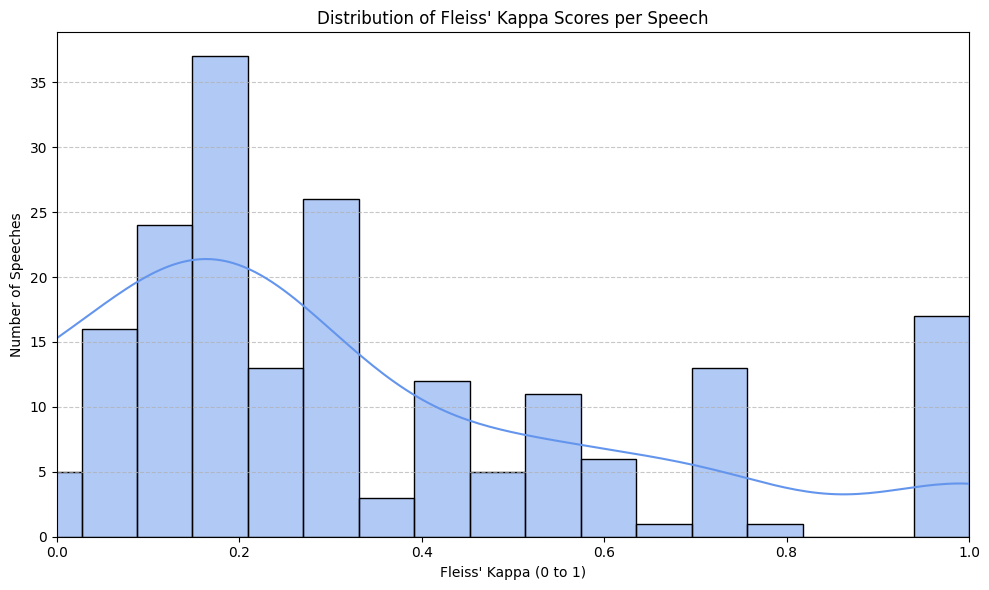

In [71]:
# STEP 1: Make sure fleiss_kappa is numeric
df_kappa['fleiss_kappa'] = pd.to_numeric(df_kappa['fleiss_kappa'], errors='coerce')

# STEP 2: Drop NaNs
df_kappa = df_kappa.dropna(subset=['fleiss_kappa'])

# STEP 3: Confirm range of values
print(df_kappa['fleiss_kappa'].describe())

# STEP 4: Plot histogram with correct x-range
plt.figure(figsize=(10, 6))
sns.histplot(df_kappa['fleiss_kappa'], bins=20, kde=True, color='cornflowerblue')
plt.title("Distribution of Fleiss' Kappa Scores per Speech")
plt.xlabel("Fleiss' Kappa (0 to 1)")
plt.ylabel("Number of Speeches")
plt.xlim(0, 1)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [72]:
print(df_kappa['fleiss_kappa'].describe())

count    220.000000
mean       0.288268
std        0.306008
min       -0.216216
25%        0.100000
50%        0.176829
75%        0.451220
max        1.000000
Name: fleiss_kappa, dtype: float64


## Identifying outliers

First I will copy code to recompute the original dataset

In [61]:
# orginal clean
df_clean

,speech_id,worker_id,answer
0,301KG0KXAZ355GRD9LSX6LBA2CHH2H,A1NBQ61Y6KO3O9,"[Market regulation, Middle Class & Professiona..."
1,301KG0KXAZ355GRD9LSX6LBA2CHH2H,A1X47COW2Y9SEL,[Market regulation]
2,301KG0KXAZ355GRD9LSX6LBA2CHH2H,A335R4YE2E34H6,[Market regulation]
3,302OLP89EMP3TBB1087B1CXS184CAA,A1NBQ61Y6KO3O9,"[Government and administrative efficiency, Eco..."
4,302OLP89EMP3TBB1087B1CXS184CAA,A1X47COW2Y9SEL,[Economic Goals]
...,...,...,...
648,3ZXNP4Z3AE3EDD796IOQU4LPUM0L7M,A1NBQ61Y6KO3O9,"[Middle Class & Professional Groups, Market re..."
649,3ZXNP4Z3AE3EDD796IOQU4LPUM0L7M,A1X47COW2Y9SEL,"[Market regulation, Government and administrat..."
650,3ZXNP4Z3AE3EDD796IOQU4LPUM0L7M,A3GS2NTQ4XU059,[Free Market Economy]
651,3ZXV7Q5FKY6YP2S9BOT3FD8JYOHCFN,A1X47COW2Y9SEL,"[Market regulation, Anti-Growth Economy]"


Now I will drop a worker from df_clean - In order to drop a different worker, change the worker_to_delete id then re-run this file

In [15]:
worker_to_delete = 'A1BQ37ZGUM16XI'
worker_column = df_clean['worker_id']

# now loop through df_clean and remove entries related to this worker
df_clean = df_clean[worker_column != worker_to_delete]
df_clean = df_clean.reset_index(drop=True)

df_clean

,speech_id,worker_id,answer
0,301KG0KXAZ355GRD9LSX6LBA2CHH2H,A1NBQ61Y6KO3O9,"[Market regulation, Middle Class & Professiona..."
1,301KG0KXAZ355GRD9LSX6LBA2CHH2H,A1X47COW2Y9SEL,[Market regulation]
2,301KG0KXAZ355GRD9LSX6LBA2CHH2H,A335R4YE2E34H6,[Market regulation]
3,302OLP89EMP3TBB1087B1CXS184CAA,A1NBQ61Y6KO3O9,"[Government and administrative efficiency, Eco..."
4,302OLP89EMP3TBB1087B1CXS184CAA,A1X47COW2Y9SEL,[Economic Goals]
...,...,...,...
648,3ZXNP4Z3AE3EDD796IOQU4LPUM0L7M,A1NBQ61Y6KO3O9,"[Middle Class & Professional Groups, Market re..."
649,3ZXNP4Z3AE3EDD796IOQU4LPUM0L7M,A1X47COW2Y9SEL,"[Market regulation, Government and administrat..."
650,3ZXNP4Z3AE3EDD796IOQU4LPUM0L7M,A3GS2NTQ4XU059,[Free Market Economy]
651,3ZXV7Q5FKY6YP2S9BOT3FD8JYOHCFN,A1X47COW2Y9SEL,"[Market regulation, Anti-Growth Economy]"


Now recompute the dictionary needed to compute the average fleiss kappa - this will be the same code but slightly modified

In [25]:

df_clean['answer'] = df_clean['answer'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_filtered = df_clean[df_clean['answer'].apply(lambda x: isinstance(x, list) and len(x) > 0)] 

speech_dfs = {} # result dict

for speech_id, group in df_filtered.groupby('speech_id'):
    if len(group) != 3:
        continue  # skip if not exactly 3 annotations

    df = pd.DataFrame(index=unique_categories)  # rows = categories
    for i, (_, row) in enumerate(group.iterrows()):
        worker_label = row['worker_id']
        df[worker_label] = df.index.map(lambda category: 1 if category in row['answer'] else 0)

    speech_dfs[speech_id] = df

    speech_dfs['301KG0KXAZ355GRD9LSX6LBA2CHH2H']

        


In [17]:


# Store results
kappa_scores = []

for speech_id, df in speech_dfs.items():
    # Each row is a category → count number of 1s and 0s across workers
    count_matrix = []
    for _, row in df.iterrows():
        counts = [list(row).count(0), list(row).count(1)]  # [num 0s, num 1s]
        count_matrix.append(counts)

    count_array = np.array(count_matrix)

    # Compute Fleiss' Kappa
    try:
        kappa = fleiss_kappa(count_array)
    except Exception as e:
        print(f"Error on {speech_id}: {e}")
        kappa = np.nan

    kappa_scores.append({
        'speech_id': speech_id,
        'fleiss_kappa': kappa
    })

# Convert to DataFrame
df_kappa = pd.DataFrame(kappa_scores)

In [18]:
df_kappa

,speech_id,fleiss_kappa
0,301KG0KXAZ355GRD9LSX6LBA2CHH2H,0.723684
1,306996CF7J2OPI6VQPINFRY7FTYB1E,-0.135135
2,3087LXLJ79YEVAXTZ80JKC6IPZKF0X,0.485714
3,308KJXFUKEOKFSDCMU21QMXWPU4ATR,0.416667
4,30EMX9PEW71PC59J9LA0AV46S08KS5,-0.105263
...,...,...
136,3YLTXLH3E2O1XNSJBJ392YJ3DM9HP4,0.723684
137,3YZ7A3YHSSBMUMOG2Y6U86LOVAD5S5,0.151515
138,3ZUE82NE1XJWDZ2WUCDYDRC08AKF8Y,0.222222
139,3ZURAPD29V5E2ZIBVR4JYHPSURQF10,0.485714


In [19]:
avg_kappa = df_kappa['fleiss_kappa'].mean()
print(f"Average Fleiss' Kappa: {avg_kappa:.3f}")

Average Fleiss' Kappa: 0.315


count    141.000000
mean       0.315226
std        0.302278
min       -0.135135
25%        0.091892
50%        0.227941
75%        0.545946
max        1.000000
Name: fleiss_kappa, dtype: float64


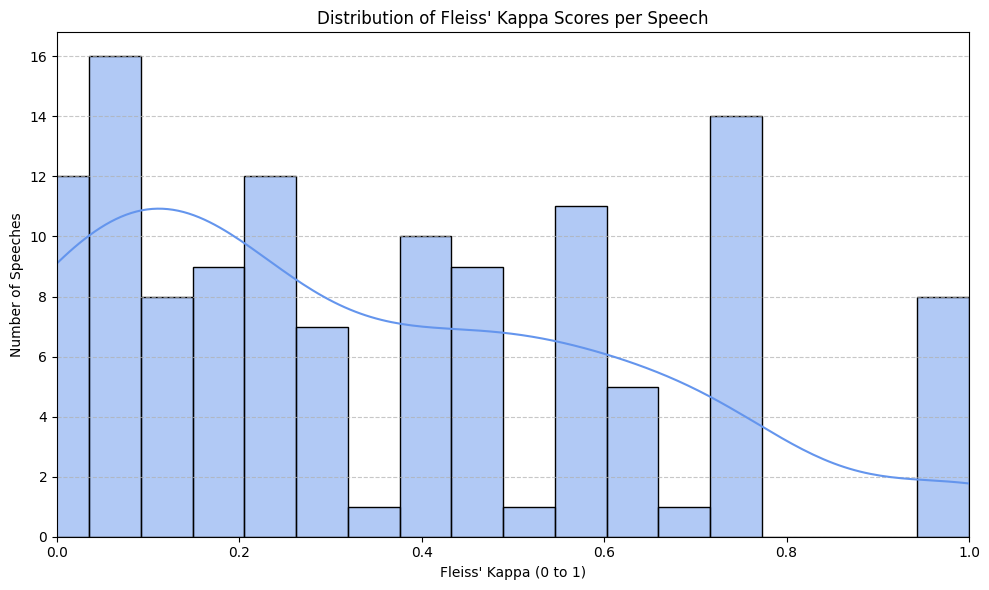

In [20]:
# STEP 1: Make sure fleiss_kappa is numeric
df_kappa['fleiss_kappa'] = pd.to_numeric(df_kappa['fleiss_kappa'], errors='coerce')

# STEP 2: Drop NaNs
df_kappa = df_kappa.dropna(subset=['fleiss_kappa'])

# STEP 3: Confirm range of values
print(df_kappa['fleiss_kappa'].describe())

# STEP 4: Plot histogram with correct x-range
plt.figure(figsize=(10, 6))
sns.histplot(df_kappa['fleiss_kappa'], bins=20, kde=True, color='cornflowerblue')
plt.title("Distribution of Fleiss' Kappa Scores per Speech")
plt.xlabel("Fleiss' Kappa (0 to 1)")
plt.ylabel("Number of Speeches")
plt.xlim(0, 1)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Inter-Annotator Agreement

In [21]:
pairwise_kappas = []

for speech_id, df in speech_dfs.items():
    try:

        worker_ids = df.columns.tolist()
        if len(worker_ids) != 3:
            raise ValueError(f"Expected 3 worker IDs for {speech_id}, got {len(worker_ids)}")
        w1, w2, w3 = worker_ids

        kappa12 = cohen_kappa_score(df[w1], df[w2])
        kappa13 = cohen_kappa_score(df[w1], df[w3])
        kappa23 = cohen_kappa_score(df[w2], df[w3])

        pairwise_kappas.append({
            'speech_id': speech_id,
            f'cohen_kappa_{w1}_vs_{w2}': kappa12,
            f'cohen_kappa_{w1}_vs_{w3}': kappa13,
            f'cohen_kappa_{w2}_vs_{w3}': kappa23,
            'avg_pairwise_kappa': np.mean([kappa12, kappa13, kappa23])
        })
    except Exception as e:
        print(f"Error computing Cohen's Kappa for {speech_id}: {e}")
        pairwise_kappas.append({
            'speech_id': speech_id,
            'avg_pairwise_kappa': np.nan
        })

# Convert to DataFrame
df_pairwise_kappa = pd.DataFrame(pairwise_kappas).fillna(np.nan)
df_pairwise_kappa

,speech_id,cohen_kappa_A1NBQ61Y6KO3O9_vs_A1X47COW2Y9SEL,cohen_kappa_A1NBQ61Y6KO3O9_vs_A335R4YE2E34H6,cohen_kappa_A1X47COW2Y9SEL_vs_A335R4YE2E34H6,avg_pairwise_kappa,cohen_kappa_A1NBQ61Y6KO3O9_vs_A3GS2NTQ4XU059,cohen_kappa_A1NBQ61Y6KO3O9_vs_APXGSUB250NVH,cohen_kappa_A3GS2NTQ4XU059_vs_APXGSUB250NVH,cohen_kappa_A1X47COW2Y9SEL_vs_A3GS2NTQ4XU059,cohen_kappa_A335R4YE2E34H6_vs_A3GS2NTQ4XU059,cohen_kappa_A335R4YE2E34H6_vs_APXGSUB250NVH,cohen_kappa_A1X47COW2Y9SEL_vs_APXGSUB250NVH
0,301KG0KXAZ355GRD9LSX6LBA2CHH2H,0.631579,0.631579,1.000000,0.754386,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,306996CF7J2OPI6VQPINFRY7FTYB1E,-0.105263,-0.166667,-0.105263,-0.125731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3087LXLJ79YEVAXTZ80JKC6IPZKF0X,0.275862,0.758621,0.416667,0.483716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,308KJXFUKEOKFSDCMU21QMXWPU4ATR,0.440000,0.758621,-0.105263,0.364453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30EMX9PEW71PC59J9LA0AV46S08KS5,NaN,NaN,NaN,-0.095816,-0.105263,-0.105263,-0.076923,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
136,3YLTXLH3E2O1XNSJBJ392YJ3DM9HP4,NaN,NaN,0.631579,0.754386,NaN,NaN,NaN,1.000000,0.631579,NaN,NaN
137,3YZ7A3YHSSBMUMOG2Y6U86LOVAD5S5,0.317073,NaN,NaN,0.207313,-0.135135,NaN,NaN,0.440000,NaN,NaN,NaN
138,3ZUE82NE1XJWDZ2WUCDYDRC08AKF8Y,NaN,0.440000,NaN,0.203533,NaN,0.275862,NaN,NaN,NaN,-0.105263,NaN
139,3ZURAPD29V5E2ZIBVR4JYHPSURQF10,0.322581,0.588235,0.631579,0.514132,NaN,NaN,NaN,NaN,NaN,NaN,NaN


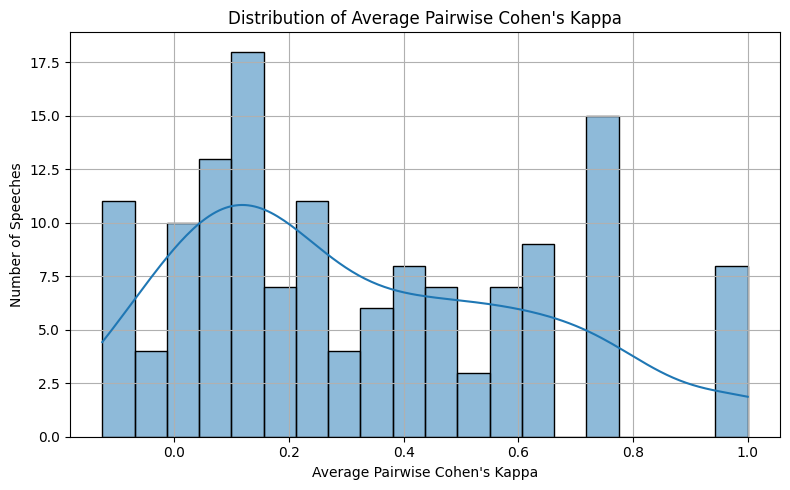

In [22]:
# Drop NaNs before plotting
valid_kappas = df_pairwise_kappa['avg_pairwise_kappa'].dropna()

plt.figure(figsize=(8, 5))
sns.histplot(valid_kappas, bins=20, kde=True, edgecolor='black')
plt.title("Distribution of Average Pairwise Cohen's Kappa")
plt.xlabel("Average Pairwise Cohen's Kappa")
plt.ylabel("Number of Speeches")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/m1/tw6x4xns6fn4nk3wf2lc_3vc0000gn/T/ipykernel_67053/3692378563.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='avg_pairwise_kappa', y='speech_id', palette='viridis')


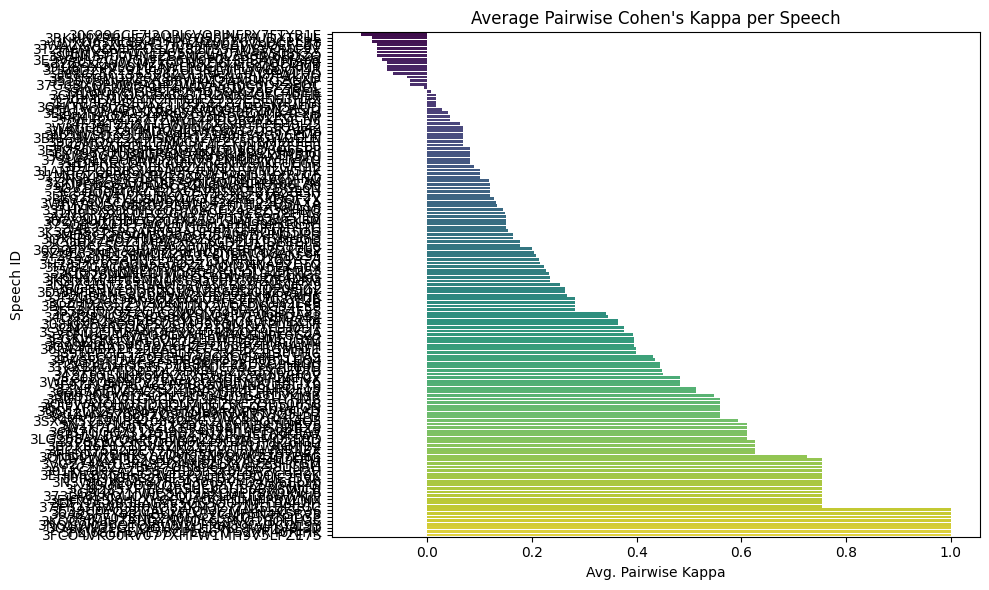

In [23]:
df_sorted = df_pairwise_kappa.sort_values(by='avg_pairwise_kappa')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted, x='avg_pairwise_kappa', y='speech_id', palette='viridis')
plt.title("Average Pairwise Cohen's Kappa per Speech")
plt.xlabel("Avg. Pairwise Kappa")
plt.ylabel("Speech ID")
plt.tight_layout()
plt.show()

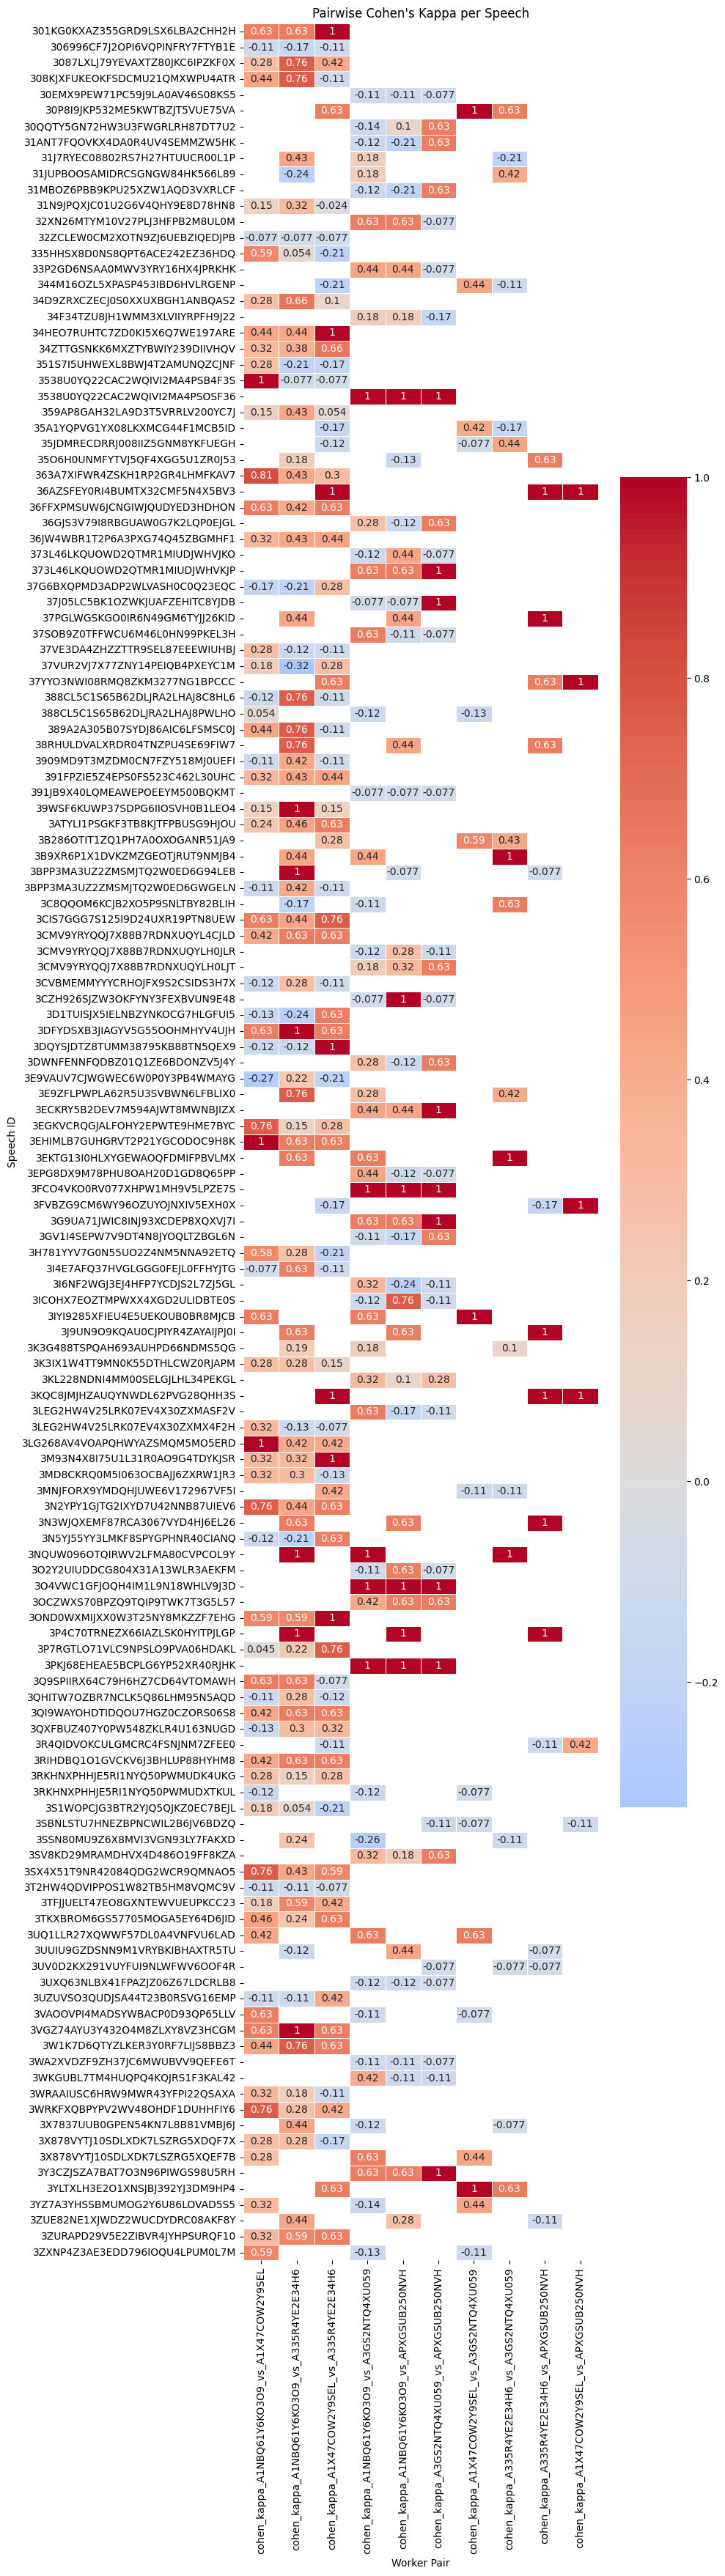

In [24]:
# Filter scores
df_heat = df_pairwise_kappa.dropna(subset=['avg_pairwise_kappa']).set_index('speech_id')
pairwise_cols = [col for col in df_heat.columns if col.startswith('cohen_kappa_')]

plt.figure(figsize=(10, len(df_heat) * 0.25))
sns.heatmap(df_heat[pairwise_cols], annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Pairwise Cohen's Kappa per Speech")
plt.xlabel("Worker Pair")
plt.ylabel("Speech ID")
plt.tight_layout()
plt.show()